In [2]:
import matplotlib.pyplot as plt
import numpy as np
#!pip install -U numba
from numba import jit
from scipy.stats import multivariate_normal
import random as rn
import eif as iso
import scipy.ndimage
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import time
import eif_old as iso2
import seaborn as sb
from sklearn.ensemble import IsolationForest

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")
import eif_new as iso_new

In [328]:
# Create data
mean = [0, 0, 0 ]
cov = [[1, 0, 0.], [0, 0.1, 0.0], [0,0,1]]  # diagonal covariance
Nobjs = 5000
np.random.seed(1)
x, y, z = np.random.multivariate_normal(mean, cov, Nobjs).T
# Add manual outlier
x[0] = 3.3
y[0] = 3.3
z[0] = 3.3
X = np.array([x,y,z]).T

In [5]:
# Generate train data
#X = 0.3 * np.random.randn(1000, 10)

In [329]:
rng = 42
Ntrees = 500
Nsamples = 256

In [333]:
# scikit learn solution
ss = time.time()
F0 = IsolationForest(n_estimators=Ntrees, max_samples=Nsamples, random_state=rng).fit(X)
S0 = F0.score_samples(X)*-1
ee = time.time()
print('{:.3f} sec, Scikit Learn'.format(ee-ss))

4.195 sec, Scikit Learn


In [331]:
ss = time.time()
F1 = iso.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0, seed=rng)
S1 = F1.compute_paths(X_in=X)
ee = time.time()
print('{:.3f} sec, EIF Cython Version'.format(ee-ss))

12.376 sec, EIF Cython Version


In [334]:
ss = time.time()
F2 = iso2.iForest(X, ntrees=Ntrees, sample_size=Nsamples, ExtensionLevel=0)
S2 = F2.compute_paths(X_in=X)
ee = time.time()
print('{:.3f} sec, EIF Old Python Version'.format(ee-ss))

422.010 sec, EIF Old Python Version


In [332]:
import eif_new as iso_new
ss = time.time()
F3 = iso_new.iForest(X, ntrees=Ntrees, sample=Nsamples, exlevel=0, random_state=rng)
S3 = F3.compute_paths(X)
ee = time.time()
print('{:.3f} sec, EIF New Python Version'.format(ee-ss)) # 6.309 sec, EIF New Python Version
# 3.402 sec, EIF New Python Version score_samples0
# 5.821 sec, EIF New Python Version score_samples
# 2.097 sec, EIF New Python Version score_samples1 5000x3

15.307 sec, EIF New Python Version


Text(0.5, 0, 'Scores')

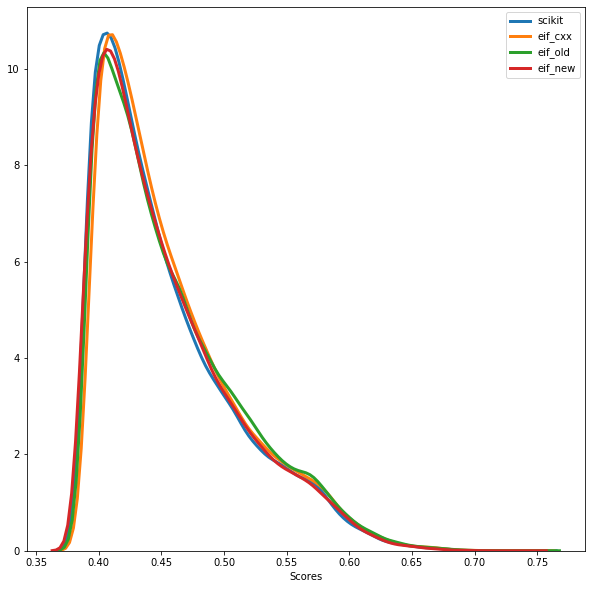

In [335]:
plt.figure(figsize=(10,10))
sb.kdeplot(S0, lw=3, label='scikit', clip=(0.35, 0.8))
sb.kdeplot(S1, lw=3, label='eif_cxx', clip=(0.35, 0.8))
sb.kdeplot(S2, lw=3, label='eif_old', clip=(0.35, 0.8))
sb.kdeplot(S3, lw=3, label='eif_new', clip=(0.35, 0.8))
plt.legend(loc=0)
plt.xlabel('Scores')

In [107]:
import joblib, os
from datetime import datetime
ext = "jbl"

t0 = datetime.now()
jbl_fn = "eif_new.%s"%ext
joblib.dump(F3, jbl_fn)
dt = datetime.now()-t0
print("%s %.2f Mb"%(dt, os.stat(jbl_fn).st_size/1024**2)) # 0:00:00.877536 0.56 Mb
# 0:00:00.407903 0.28 Mb f2 0.44 Mb f4
# 0:00:00.079145 5.49 Mb f4 u2
# 0:00:00.079248 6.95 Mb f4 i4

0:00:00.082970 5.49 Mb


In [80]:
t0 = datetime.now()
jbl_fn = "eif_old.%s"%ext
joblib.dump(F2, jbl_fn)
dt = datetime.now()-t0
print("%s %.2f Mb"%(dt, os.stat(jbl_fn).st_size/1024**2)) #0:00:32.724675 6.83 Mb
# 0:00:17.224409 3.54 Mb
# 0:00:08.227051 42.72 Mb no compression

0:00:08.227051 42.72 Mb


In [308]:
import eif_new as iso_new
F3 = iso_new.iForest(X, ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0)
#S3 = F3.compute_paths(X)

In [357]:
%timeit iso_new.iForest(X, ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0) #X.shape[1]-1)
%timeit F3.compute_paths(X)
# 749 ms ± 3.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) exlevel=0
# 361 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) without p *min-max

# 2.46 s ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 1.75 s ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) nonzero instead of argwhere
# 1.65 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) without nonzero
# 1.36 s ± 4.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) X.dot for all nodes
# 1.99 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) get_paths0

# 752 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) exlevel=2
# 2.48 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) 

751 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.99 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [338]:
def c_factor(n):
    return np.sum(2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0)))

self = F3
S = np.zeros(X.shape[0])
trees = np.array([t.nodes for t in self.Trees])
n, pdotn, left, right, sizes = trees["n"], trees["pdotn"], trees["left"], trees["right"], trees["size"]
for xi in range(1): #X.shape[0]):
    ni = np.where(X[xi].dot(n[:, 0].T) < pdotn[:, 0], left[:, 0].T, right[:, 0].T)
    tidx = np.arange(trees.shape[0])
    for e in range(1, self.limit):
        w = X[xi].dot(n[tidx, ni].T) < pdotn[tidx, ni]
        ni = np.where(w, left[tidx, ni].T, right[tidx, ni].T)
        S[xi] += e*(ni==0).sum()
        print(e, (ni==0).sum(), S[xi], len(ni))
        tidx, ni = tidx[ni>0], ni[ni>0]
    # the size matters only at terminal nodes
    size = sizes[tidx, ni]
    S[xi] += self.limit*len(ni) + c_factor(size[size>1])#.sum()
    print(self.limit, (ni==0).sum(), S[xi], len(ni), size)

1 31 31.0 500
2 58 147.0 469
3 88 411.0 411
4 100 811.0 323
5 73 1176.0 223
6 58 1524.0 150
7 42 1818.0 92
8 0 2251.2732305771265 50 [ 1  4  2  6  1  5  1  2  1  2  5  2  1  4 20  2  1  1  0  1  1 10  3  1
  1  3  1  1  3  1  1  2  1  2  1  2  1  2  2  5  1  1  1  2 26  1  1  1
  1  1]


In [311]:
ni

array([364,  30, 157,  31, 409, 329, 472,  46, 142, 189, 145, 330, 485,
       479, 446, 143,  40, 447, 176, 453, 214,  16, 244, 457, 348, 184,
        61,  39, 336, 177, 237, 428,  94, 409,  30,  19, 167, 367, 475],
      dtype=uint16)

In [306]:
S = F3.score_samples(X); S

array([0.97761337, 0.66105967, 0.51744501, ..., 0.6299805 , 0.55715247,
       0.43243751])

In [307]:
S1 = F3.score_samples1(X); S1

array([0.74400223, 0.56587012, 0.4988135 , ..., 0.54653904, 0.5134962 ,
       0.44586648])

In [87]:
trees = np.array([t.nodes for t in F3.Trees]); trees.flags, trees.dtype

(  C_CONTIGUOUS : True
   F_CONTIGUOUS : False
   OWNDATA : True
   WRITEABLE : True
   ALIGNED : True
   WRITEBACKIFCOPY : False
   UPDATEIFCOPY : False,
 dtype([('n', '<f4', (3,)), ('pdotn', '<f4'), ('left', '<u2'), ('right', '<u2'), ('size', '<u2')]))

In [69]:
trees = np.array([t.nodes for t in F3.Trees]); trees.flags, trees.dtype
#%timeit trees = np.array([t.nodes for t in F3.Trees]) #556 µs ± 998 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)

(  C_CONTIGUOUS : True
   F_CONTIGUOUS : False
   OWNDATA : True
   WRITEABLE : True
   ALIGNED : True
   WRITEBACKIFCOPY : False
   UPDATEIFCOPY : False,
 dtype([('n', '<f2', (3,)), ('pdotn', '<f2'), ('left', '<u2'), ('right', '<u2'), ('size', '<u2'), ('e', 'u1')]))

In [11]:
w = X.dot(trees[:, 0]["n"].T) < trees[:, 0]["pdotn"]
%timeit X.dot(trees[:, 0]["n"].T) < trees[:, 0]["pdotn"] #4.7 ms ± 73.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
%timeit [X.dot(t.nodes["n"][0].T) < t.nodes["pdotn"][0] for t in F3.Trees] #7.74 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

4.87 ms ± 74.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.93 ms ± 57.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [357]:
xi = ni = 0
tidx = np.arange(len(trees))
ni = np.where(X[xi].dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
ni.shape

(500,)

In [358]:
xi = ni = 0
tidx = np.arange(len(trees))
#ni = np.where(np.inner(X, trees["n"][tidx, ni]) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
ni = np.where(X.dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
ni.shape

(5000, 500)

In [430]:
%prun score_samples_by_sample_pool(X, trees, 6)

In [237]:
from numba import jit, int32, float64, float32, uint16

@jit(float32(uint16[:])) # 9.1 vs 13.5 µs
def c_factor(n):
    return np.sum(2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0)))

#@jit(float64(float64[:], float32[:,:,:], float32[:,:], uint16, uint16, uint16, uint16))
def score_sample1(x, n, pdotn, left, right, sizes, limit, ni=0, S=0):
    tidx = np.arange(trees.shape[0])
    for e in range(limit):
        w = x.dot(n[tidx, ni].T) < pdotn[tidx, ni]
        ni = np.where(w, left[tidx, ni].T, right[tidx, ni].T)
        if e: S += e*(ni==0).sum()
        tidx, ni = tidx[ni>0], ni[ni>0]
    # the size matters only at terminal nodes
    size = sizes[tidx, ni]
    S += e*len(ni) + c_factor(size[size>1])
    return S

def score_samples_by_sample1(X, trees, limit=8):
    S = np.zeros(X.shape[0])
    for xi in range(X.shape[0]):
        S[xi] = score_sample1(X[xi], trees["n"], trees["pdotn"], trees["left"], trees["right"], trees["size"], limit)
    return S * 1. / len(trees)

def score_sample(x, trees, limit, ni=0, S=0):
    tidx = np.arange(trees.shape[0])
    for e in range(limit):
        w = x.dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni]
        ni = np.where(w, trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
        if e: S += e*(ni==0).sum()
        tidx, ni = tidx[ni>0], ni[ni>0]
    # the size matters only at terminal nodes
    size = trees["size"][tidx, ni]
    S += e*len(ni) + c_factor(size[size>1])
    return S

def score_samples_by_sample(X, trees, limit=8):
    S = np.zeros(X.shape[0])
    for xi in range(X.shape[0]):
        S[xi] = score_sample(X[xi], trees, limit)
    return S * 1. / len(trees)

def score_samples_by_sample_all(X, trees, limit=8):
    S = np.zeros(X.shape[0])
    for xi in range(X.shape[0]):
        ni = 0
        tidx = np.arange(trees.shape[0])
        for e in range(limit):
            w = X[xi].dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni]
            ni = np.where(w, trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
            if e: S[xi] += e*(ni==0).sum()
            tidx, ni = tidx[ni>0], ni[ni>0]
        # the size matters only at terminal nodes
        size = trees["size"][tidx, ni]
        S[xi] += e*len(ni) + c_factor(size[size>1])
    return S * 1. / len(trees)

#%timeit score_samples_by_sample1(X, trees, F3.limit) #1.55 s ± 8.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


S = score_samples_by_sample(X, trees, F3.limit) 
%timeit score_samples_by_sample(X, trees, F3.limit) #1.64 s ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 1.87 s ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) fully functional
# 1.79 s ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
%timeit score_samples_by_sample_all(X, trees, F3.limit) #1.64 s ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# 2 s ± 4.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# 1.43 s ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) for f4 i4?
# 1.57 s ± 933 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)  for f4 u2

1.48 s ± 7.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.56 s ± 4.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.5 s ± 5.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [261]:
limit = 8
e=0; 2**(limit-e)
np.power(2, np.arange(1, limit+1))

array([  2,   4,   8,  16,  32,  64, 128, 256])

In [269]:
def score_samples_by_sample_all2(X, trees, limit=8):
    S = np.zeros(X.shape[0])
    n, pdotn, sizes = trees["n"], trees["pdotn"], trees["size"]
    #powers = np.power(2, np.arange(limit+1))
    for xi in range(X.shape[0]):
        e = 0
        ni = np.zeros(len(trees), dtype='int')
        w = X[xi].dot(n[:, 0].T) < pdotn[:, 0]
        ni[w] += 1
        ni[~w] += 2**(limit-e)
        tidx = np.arange(trees.shape[0])
        for e in range(1, limit):
            w = X[xi].dot(n[tidx, ni].T) < pdotn[tidx, ni]
            ni[w] += 1
            ni[~w] += 2**(limit-e)
            sel = sizes[tidx, ni]>1
            S[xi] += e*(~sel).sum()
            tidx, ni = tidx[sel], ni[sel]
        # the size matters only at terminal nodes
        size = sizes[tidx, ni]
        S[xi] += e*len(ni) + c_factor(size[size>1])
    return S * 1. / len(trees)

%timeit score_samples_by_sample_all1(X, trees, F3.limit)
S2 = score_samples_by_sample_all2(X, trees, F3.limit); S2
#3.512636  ,  8.05164026, 10.16188574, ...,  8.66337866,

1.42 s ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([ 3.512636  ,  8.05164026, 10.16188574, ...,  8.66337866,
        9.64911035, 11.90239893])

In [268]:
%lprun -f score_samples_by_sample_all2 score_samples_by_sample_all2(X, trees)

In [275]:
def score_samples_by_sample_all1(X, trees, limit=8):
    S = np.zeros(X.shape[0])
    n, pdotn, left, right, sizes = trees["n"], trees["pdotn"], trees["left"], trees["right"], trees["size"]
    for xi in range(X.shape[0]):
        ni = np.where(X[xi].dot(n[:, 0].T) < pdotn[:, 0], left[:, 0].T, right[:, 0].T)
        tidx = np.arange(trees.shape[0])
        for e in range(1, limit):
            w = X[xi].dot(n[tidx, ni].T) < pdotn[tidx, ni]
            ni = np.where(w, left[tidx, ni].T, right[tidx, ni].T)
            S[xi] += e*(ni==0).sum()
            tidx, ni = tidx[ni>0], ni[ni>0]
        # the size matters only at terminal nodes
        size = sizes[tidx, ni]
        S[xi] += e*len(ni) + c_factor(size[size>1])
    return S * 1. / len(trees)

%timeit score_samples_by_sample_all1(X, trees, F3.limit)
# 1.4 s ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

S1 = score_samples_by_sample_all1(X, trees, F3.limit); S1

1.42 s ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


array([ 4.370636  ,  8.41564026, 10.27988574, ...,  8.92937866,
        9.85111035, 11.93839893])

In [276]:
#!pip install line_profiler
%load_ext line_profiler
%lprun -f score_samples_by_sample_all1 score_samples_by_sample_all1(X, trees)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [277]:
w

array([False,  True, False, False,  True,  True, False,  True, False,
        True, False,  True, False, False,  True,  True, False, False,
        True, False, False, False, False,  True,  True,  True, False,
        True, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True, False,  True,  True,  True, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False,  True,  True, False,  True, False, False,
       False,  True, False,  True,  True,  True, False, False, False,
       False, False, False, False,  True, False,  True,  True, False,
        True,  True, False, False, False, False, False,  True, False,
        True, False,  True, False, False,  True, False, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False, False, False,  True,  True, False, False, False,
        True,  True,

In [278]:
import eif_new as iso_new
F3 = iso_new.iForest(X, ntrees=Ntrees, sample=Nsamples, random_state=rng, exlevel=0)
trees = np.array([t.nodes for t in F3.Trees]); trees.flags, trees.dtype

S = np.zeros(X.shape[0])
xi = ni = e = 0
tidx = np.arange(trees.shape[0])

In [290]:
w = X.dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni]
X.shape, trees["n"][tidx, ni].T.shape, w.shape


((5000, 3), (500, 3), (5000, 500))

In [292]:
#w[:10,:10]
#X[w]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 3 but corresponding boolean dimension is 500

In [ ]:
ni = np.where(w, trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
if e: S[xi] += e*(ni==0).sum()
print(e, (ni<1).sum(), ni)
tidx, ni = tidx[ni>0], ni[ni>0]
e += 1

In [284]:
[trees[["left", "right"]][:, 0]]
%timeit X[xi].dot(trees["n"][tidx, ni].T).shape
X[xi].shape, trees["n"][tidx, ni].T.shape, X[xi].dot(trees["n"][tidx, ni].T).shape

10 µs ± 21.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


((3,), (3, 500), (500,))

In [283]:
%timeit X.dot(trees["n"][tidx, ni].T).shape
X.shape, trees["n"][tidx, ni].T.shape, X.dot(trees["n"][tidx, ni].T).shape

3.78 ms ± 81.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


((5000, 3), (3, 500), (5000, 500))

In [287]:
#ni, tidx, 

(array([256,   1, 256,   1,   1,   1,   1, 256,   1,   1,   1,   1,   1,
          1, 256, 256, 256,   1,   1, 256,   1,   1, 256,   1,   1, 256,
        256, 256,   1, 256, 256, 256,   1,   1,   1,   1, 256,   1, 256,
          1,   1,   1, 256,   1,   1,   1, 256,   1,   1,   1, 256,   1,
          1,   1, 256,   1,   1, 256,   1,   1,   1, 256,   1, 256,   1,
        256,   1,   1, 256, 256,   1,   1,   1, 256, 256, 256,   1, 256,
          1,   1,   1,   1, 256, 256, 256, 256,   1,   1, 256,   1, 256,
        256,   1,   1,   1, 256,   1,   1, 256,   1,   1,   1, 256, 256,
        256,   1,   1,   1,   1,   1, 256,   1,   1,   1, 256,   1, 256,
          1,   1,   1,   1,   1,   1,   1,   1,   1, 256, 256,   1,   1,
          1, 256,   1, 256, 256,   1,   1,   1,   1,   1,   1,   1,   1,
          1, 256,   1,   1,   1, 256,   1, 256, 256,   1, 256,   1,   1,
          1, 256,   1,   1,   1,   1, 256, 256, 256, 256,   1, 256,   1,
        256,   1, 256,   1,   1,   1,   1, 256, 256

In [279]:
#for e in range(limit):
pni = ni
w = X[xi].dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni]
ni = np.where(w, trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
if e: S[xi] += e*(ni==0).sum()
print(e, (ni<1).sum(), ni)
tidx, ni = tidx[ni>0], ni[ni>0]
e += 1

0 0 [256   1 256   1   1   1   1 256   1   1   1   1   1   1 256 256 256   1
   1 256   1   1 256   1   1 256 256 256   1 256 256 256   1   1   1   1
 256   1 256   1   1   1 256   1   1   1 256   1   1   1 256   1   1   1
 256   1   1 256   1   1   1 256   1 256   1 256   1   1 256 256   1   1
   1 256 256 256   1 256   1   1   1   1 256 256 256 256   1   1 256   1
 256 256   1   1   1 256   1   1 256   1   1   1 256 256 256   1   1   1
   1   1 256   1   1   1 256   1 256   1   1   1   1   1   1   1   1   1
 256 256   1   1   1 256   1 256 256   1   1   1   1   1   1   1   1   1
 256   1   1   1 256   1 256 256   1 256   1   1   1 256   1   1   1   1
 256 256 256 256   1 256   1 256   1 256   1   1   1   1 256 256   1 256
   1   1 256 256 256   1 256 256 256   1   1 256 256 256 256 256   1   1
   1   1 256 256 256 256   1 256   1 256   1   1 256   1 256   1 256   1
 256   1   1 256 256   1   1 256 256 256   1 256 256   1   1 256 256   1
 256   1   1 256 256   1 256 256   1 256   1   

In [ ]:
# the size matters only at terminal nodes
size = trees["size"][tidx, ni]
S[xi] += e*len(ni) + c_factor(size[size>1])

In [169]:
def score_samples_by_sample_all2(X, trees, limit=8):
    S = np.zeros(X.shape[0])
    n, pdotn, left, right, sizes = trees["n"], trees["pdotn"], trees["left"], trees["right"], trees["size"]
    for xi in range(X.shape[0]):
        ni = 0
        tidx = np.arange(trees.shape[0])
        w = X[xi].dot(n[:, ni].T) < pdotn[:, ni]
        _w = np.empty_like(w)
        l = r = 0
        for e in range(1, limit):
            l, r = left[0, l], right[0, r]
            _w[w] = X[xi].dot(n[tidx[w], l].T) < pdotn[tidx[w], l]
            _w[~w] = X[xi].dot(n[tidx[~w], r].T) < pdotn[tidx[~w], r]
            ni = np.where(w, left[tidx, ni].T, right[tidx, ni].T)
            S[xi] += e*(ni==0).sum()
            tidx, ni = tidx[ni>0], ni[ni>0]
        # the size matters only at terminal nodes
        size = sizes[tidx, ni]
        S[xi] += e*len(ni) + c_factor(size[size>1])
    return S * 1. / len(trees)

%timeit score_samples_by_sample_all1(X, trees, F3.limit)

1.48 s ± 6.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [219]:
#n, pdotn, childs, sizes = trees["n"], trees["pdotn"], trees["childs"], trees["size"]
xi = ni = 0
e = 1
tidx = np.arange(trees.shape[0])
w = X[xi].dot(trees["n"][:, ni].T) < trees["pdotn"][:, ni]
_w = np.empty_like(w)
l = r = 0

In [223]:
w.shape, tidx.shape, w.sum() #((500,), (500,), 268)
#trees["left"][tidx[w], l]

((500,), (500,), 268)

In [225]:
l, r = trees["left"][tidx[w], l], trees["right"][tidx[~w], r] #trees["childs"][l]  # trees["childs"][0, l] 
_w[w] = X[xi].dot(trees["n"][tidx[w], l].T) < trees["pdotn"][tidx[w], l]
_w[~w] = X[xi].dot(trees["n"][tidx[~w], r].T) < trees["pdotn"][tidx[~w], r]
w = _w

#S[xi] += e*(ni==0).sum()
#tidx, ni = tidx[ni>0], ni[ni>0]
print(e, l, r, w.sum())
e += 1


1 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1] [256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256
 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256
 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256
 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256
 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256
 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256
 256 256 256 25

In [226]:
w.shape, tidx.shape, l.shape, w.sum() #((500,), (500,), 268)
#trees["left"][tidx[w], l]

((500,), (500,), (268,), 231)

In [189]:
trees["childs"][0, l]

array([  1, 256], dtype=uint16)

In [236]:
#!pip install line_profiler
%load_ext line_profiler
%lprun -f score_samples_by_sample_all1 score_samples_by_sample_all1(X, trees)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [428]:
def worker(args):
    Xi = args
    ni = 0
    S = 0
    tidx = np.arange(trees.shape[0])
    for e in range(F3.limit):
        pni = ni
        ni = np.where(Xi.dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
        sel = ni>0
        if e: S += e*(~sel).sum()
        tidx, ni = tidx[sel], ni[sel]
    # the size matters only at terminal nodes
    size = trees[tidx, ni]["size"]
    S += e*len(ni) + c_factor(size[size>1]).sum()  
    return S

def score_samples_by_sample_pool(X, trees, nproc=6):
    S = np.zeros(X.shape[0])
    import multiprocessing as mp
    with mp.Pool(nproc) as p:
        iterable = (X[xi] for xi in range(X.shape[0]))
        for i, si in enumerate(p.imap(worker, iterable, 100)):
            S[i] = si
    return S/len(trees)

#%timeit score_samples_by_sample_pool(X, trees, 1) #1.96 s ± 50.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#%timeit score_samples_by_sample_pool(X, trees, 6) #  484 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
for i in range(1, 13):
    print(i)
    %timeit score_samples_by_sample_pool(X, trees, i) #  484 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

1
2.02 s ± 771 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2
1.07 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3
740 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4
652 ms ± 626 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
5
562 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6
577 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
7
587 ms ± 27.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8
562 ms ± 49.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9
543 ms ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10
555 ms ± 43.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11
553 ms ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12
537 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [431]:
%prun score_samples_by_sample(X, trees)

In [ ]:
def score_samples_by_tree(X, trees):
    S = np.zeros(X.shape[0])
    for ti in range(len(trees)):
        ni = 0
        xidx = np.arange(X.shape[0])
        for e in range(F3.limit+1):
            pni = ni
            ni = np.where(X.dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
            tidx, ni = tidx[ni>0], ni[ni>0]
            S[xi] += e*len(ni<1) # + c_factor(size) #trees[tidx[ni<1], pni[ni<1]][["size", "e"]]
    return S

%timeit score_sample_by_sample(X, trees) #1.64 s ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [235]:
pni = ni
ni = np.where(X[xi].dot(trees["n"][tidx, ni].T) < trees["pdotn"][tidx, ni], trees["left"][tidx, ni].T, trees["right"][tidx, ni].T)
print(trees[tidx[ni<1], pni[ni<1]][["size", "e"]]) #ni.shape, ni[:10])#, trees[tidx[ni<1], ni[ni<1]]["e"])
tidx, ni = tidx[ni>0], ni[ni>0]


[]
